In [ ]:
# uncomment here if you need to install the relevant packages
# !pip install gymnasium 
# !pip install numpy

# Reinforcement Learning Lab 1: Tabular RL
---
In this lab session we will aim to accomplish the following:
- An introduction to [Gym(nasium)](https://gymnasium.farama.org); a commonly used package with benchmark RL environments;
- Look at exact Dynamic Programming methods;
- Run and compare Monte-Carlo and Temporal Difference based algorithms;
- Write code that visualises the results of training the various algorithms.

Note that I've tried to highlight in **bold** parts of the lab that you can do yourself, or questions that you can discuss with the person sitting next to you, or ask me about in the lab. 

### First, we will begin by installing Gym and looking at it's functionality. 
Gym is an important framework in RL because it provides a standardised interface for interacting with RL environments, allowing researchers and practitioners to easily compare the performance of different RL algorithms on a wide range of environments. It also provides a collection of diverse and challenging environments that can be used for benchmarking and testing new algorithms.

Now, let's take a look at how a gym environment works! We will start by creating a copy of a Blackjack environment. For any regular Blackjack players, information about the specific rules of this Blackjack game can be found in the [documentation](https://gymnasium.farama.org/environments/toy_text/blackjack/), with a major difference between this implementation and that of a real casino is that the cards are drawn from an infinite deck. 

In [1]:
import gymnasium as gym
env = gym.make('Blackjack-v1')

As we can see, to create a copy of an environment we use the command `gym.make()` with a string of the environment name that we'd like to create. For more environment names that can be used, you can look at the Gym documentation that was linked above. The format is usually *env_name*-*version*, so be careful to specify the most recent version -- this again can be found in the documentation; for example, if we go to the documentation for the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/) we can scroll down to see the version history. 

The environment object provides us with information about the environment, most importantly about the state and action space:

In [2]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


From the output, we can see that the observation space is a 3-tuple. Here, `Discrete(N)` simply means that we have `N` discrete options. For the state space, this corresponds to the players current sum, the value of the dealers visible card, and whether or not the player holds a useable ace, respectively. The action space is simply whether to hit or stick. The rewards for the game are +1 for winning, +1.5 for winning with a 'natural' blackjack, -1 for losing and 0 for a draw. The episode ends whenever a player sticks, when a player hits and the sum of the cards exceeds 21, or if the player has blackjack. 

Now that we have the environment set up, we can play a game using a random policy!

In [3]:
import numpy as np
np.random.seed(3)
random_blackjack_scores = []
for episode in range(10000):
    state, _ = env.reset()  # this is how we reset the environment.
    done = False  # this tells us that the game is not over yet.
    score = 0  # to keep track of the rewards during the episode.
    while not done: 
        action = env.action_space.sample()  # this samples an action uniformly at random from the action space.
        next_state, reward, terminated, truncated, _ = env.step(action)  # here we take a step in the env using the sampled action.
        score += reward  # add on the observed reward.
        done = terminated or truncated  # tells us whether the episode is over.
        state = next_state  # here we reset the current state variable to be the next state from the previous transition.
    random_blackjack_scores.append(score)
print(f"The random policy got an average score of {np.mean(random_blackjack_scores)}")

The random policy got an average score of -0.406


The above loop is something you will see a lot whilst learning Reinforcement Learning, and is why the gym framework is a valuable asset as it provides a simple, clean way of looping through episodes of an environment. Note that when we reset the environment, `env.reset()` will actually return two objects -- the `state` and `info` (which we assign to an unnamed variable). The `info` is there to tell us if there are any problems with the environment or any bits of information that may be useful, and is only really used for debugging if something is going wrong. It is also returned when calling `env.step()`, but for now we don't need to worry about it. 

The other thing to note is that we are returned a `terminated` and a `truncated` flag by the environment when we take a step. This is not something we need to worry about for Blackjack, but in continuing problems (i.e. those with no terminal states), or those with very long time horizons, it can be useful to reset the environment whilst training before an episode ends. However, we don't want to treat this as a terminal state, and so the `terminated` flag is what we use to tell the algorithm whether or not the state is terminal, whereas the `truncated` flag is for our use in training to tell us whether or not we should reset the environment, so during training we now have two reset conditions: whether the state was truly terminal, or whether we are truncating the episode. 

Now let's have a look at implementing our own environments. This is useful for research purposes as you may want to make your own toy environment for ablation studies etc. Today we will write a simple gridworld environment (with some variants) that we will test some tabular algorithms on later. 

Gridworld is a classic environment where we have an $N \times M$ grid (usually $N = M$) and we have to navigate from some starting state to a goal state taking the primitive directions as actions (up/down/left/right). It is a useful environment because we can control the difficulty by e.g. introducing obstacles, or having the goal state changing constantly, but for now we will keep it simple. Let's look at the code:

In [8]:
from gymnasium import spaces
import numpy as np

class Gridworld(gym.Env):
    def __init__(self, grid_size):
        super(Gridworld, self).__init__()

        self.grid_size = grid_size
        self.num_rows = grid_size
        self.num_cols = grid_size
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Discrete(grid_size * grid_size)

        self.start_state = 0
        self.goal_state = grid_size * grid_size - 1
        self.current_state = self.start_state

    def reset(self):
        self.current_state = self.start_state
        return self.current_state, {}

    def step(self, action):
        x, y = self._state_to_position(self.current_state)

        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.grid_size - 1, y + 1)

        new_state = self._position_to_state(x, y)
        self.current_state = new_state

        done = False
        reward = -1

        if self.current_state == self.goal_state:
            done = True

        return new_state, reward, done, False, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        x, y = self._state_to_position(self.current_state)
        grid[x][y] = 1
        print(grid)

    def _state_to_position(self, state):
        x = state // self.grid_size
        y = state % self.grid_size
        return x, y

    def _position_to_state(self, x, y):
        return x * self.grid_size + y

We can see that the class inherits from `gym.Env` (this is useful if you want to use your environment with Stable Baselines, where they expect a gym environment to be specified) and we specify the state(/observation) and action space. We also provide the `reset` and `step` methods, which as we saw with the Blackjack example are how we control the environment. We also added the `render` method which will print out the current grid with the agents location. Next, we will write code for a 'windy' gridworld, where in the middle of the grid there is a wind that will blow all transitions upwards by an extra square, and a cliff walking gridworld where the agent starts in the bottom left of the grid, and must reach the bottom right, but the rest of the bottom row is a cliff that if the agent steps onto will result in the end of an episode with a reward of -100. These environments are taken from Example 6.5 and 6.6 of the Sutton and Barto textbook, respectively. Note that these two classes have a `max_steps` attribute -- this will truncate all episodes once they reach this many steps.

In [9]:
class WindyGridworld(gym.Env):
    def __init__(self):
        super(WindyGridworld, self).__init__()

        self.grid_size = (7, 10)
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Discrete(self.grid_size[0] * self.grid_size[1])

        self.start_state = (3, 0)
        self.goal_state = (3, 7)
        self.current_state = self.start_state
        self.wind = [0, 0, 0, 1, 1, 1, 1, 1, 1, 0]
        self.max_steps = 500
        self.steps = 0

    def reset(self):
        self.current_state = self.start_state
        self.steps = 0
        return self._state_to_index(self.current_state), {}

    def step(self, action):
        self.steps += 1
        x, y = self.current_state

        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.grid_size[0] - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.grid_size[1] - 1, y + 1)

        x = max(0, x - self.wind[y])  # apply the wind

        new_state = (x, y)
        self.current_state = new_state

        done = False
        reward = -1

        if self.current_state == self.goal_state:
            done = True
            reward = 0

        return self._state_to_index(new_state), reward, done, self.steps == self.max_steps, {}

    def render(self):
        grid = np.zeros(self.grid_size)
        x, y = self.current_state
        grid[x][y] = 1
        print(grid)

    def _state_to_index(self, state):
        x, y = state
        return x * self.grid_size[1] + y

    def _index_to_state(self, index):
        x = index // self.grid_size[1]
        y = index % self.grid_size[1]
        return x, y

In [10]:
class CliffWalking(gym.Env):
    def __init__(self):
        super(CliffWalking, self).__init__()

        self.grid_size = (4, 12)
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Discrete(self.grid_size[0] * self.grid_size[1])

        self.start_state = (3, 0)
        self.goal_state = (3, 11)
        self.current_state = self.start_state

        self.cliff = [(3, i) for i in range(1, 11)]
        self.steps = 0
        self.max_steps = 500

    def reset(self):
        self.steps = 0
        self.current_state = self.start_state
        return self._state_to_index(self.current_state), {}

    def step(self, action):
        self.steps += 1
        x, y = self.current_state

        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.grid_size[0] - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.grid_size[1] - 1, y + 1)

        new_state = (x, y)
        self.current_state = new_state

        done = False
        reward = -1

        if self.current_state in self.cliff:
            reward = -100
            self.current_state = self.start_state

        if self.current_state == self.goal_state:
            done = True
            reward = 0

        return self._state_to_index(new_state), reward, done, self.steps == self.max_steps, {}

    def render(self):
        grid = np.zeros(self.grid_size)
        x, y = self.current_state
        grid[x][y] = 1
        print(grid)

    def _state_to_index(self, state):
        x, y = state
        return x * self.grid_size[1] + y

    def _index_to_state(self, index):
        x = index // self.grid_size[1]
        y = index % self.grid_size[1]
        return x, y

Take a quick look over the code for these two additional classes to make sure you understand what's going on, then we'll take a look at _evaluating_ a policy. 

### Policy evaluation
Recall from your lecture slides that we can evaluate a policy using the update rule $v_{k+1}(s) \leftarrow \mathbb{E}_\pi[R_{t+1} + \gamma v_k(S_{t=1}) | S_t = s]$. **Defining some arbitrary policy (e.g. one that selects each action at random) can you write a function that would implement policy evaluation? You will need to make sure that you loop through all states, performing the update for each, *except* for the terminal state (i.e. bottom right state) -- ensure that this is always kept at a value of 0, as this is how we define a terminal state. Use `matplotlib` to plot the values of your policy. Can you define a custom policy that would be an optimal solution, and if so, what do the values look like?**

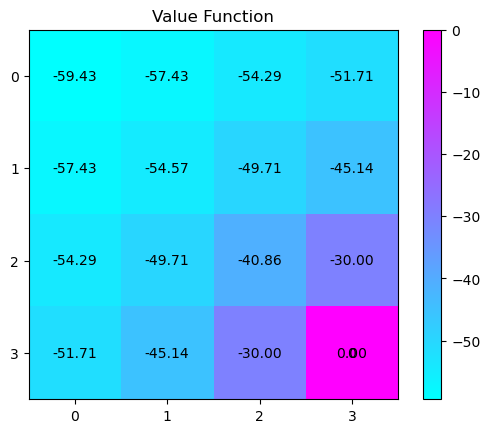

In [13]:
import matplotlib.pyplot as plt

def policy_evaluation(env, policy, gamma, theta):
    return  # fill this in yourselves


def get_transitions(env, state, action):
    """
    You will need to use this function in your policy eval function to return the transition dynamics p(s', r|s, a).
    It essentially just uses the same logic as in the `step` method of the gridworld class. 
    """
    x, y = env._state_to_position(state)

    if action == 0:  # Up
        x = max(0, x - 1)
    elif action == 1:  # Down
        x = min(env.grid_size - 1, x + 1)
    elif action == 2:  # Left
        y = max(0, y - 1)
    elif action == 3:  # Right
        y = min(env.grid_size - 1, y + 1)

    new_state = env._position_to_state(x, y)

    done = False
    reward = -1

    if state == env.goal_state:
        done = True
        reward = -1

    return new_state, reward, done


def plot_value_function(env, value_function):
    num_rows, num_cols = env.grid_size, env.grid_size
    grid = np.zeros((num_rows, num_cols))

    for state in range(len(value_function)):
        row, col = env._state_to_position(state)
        grid[row][col] = value_function[state]

    grid[-1][-1] = 0

    fig, ax = plt.subplots()
    im = ax.imshow(grid, cmap='cool')

    for i in range(num_rows):
        for j in range(num_cols):
            value = grid[i][j]
            ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')
    ax.text(num_cols - 1, num_rows - 1, 0, ha='center', va='center', color='black')

    ax.set_xticks(np.arange(num_cols))
    ax.set_yticks(np.arange(num_rows))
    ax.set_xticklabels(np.arange(num_cols))
    ax.set_yticklabels(np.arange(num_rows))
    ax.set_title('Value Function')
    plt.colorbar(im)
    plt.show()


env = Gridworld(4)
policy = {s: np.ones(env.action_space.n) / env.action_space.n for s in range(env.observation_space.n)}  # change this if you like, np.random.dirichlet can be useful
value_function = policy_evaluation(env, policy, 1, 0.000001)
plot_value_function(env, value_function)

### Value Iteration
Now we will look to extract a policy that is approximately optimal using value iteration. **Using the pseudocode from your lecture slides, write a function that performs value iteration and will output a deterministic policy such that $\pi(s) = \arg\max_a\sum_{s', r}p(s', r|s, a)[r + \gamma V(s')]$ (you may also want to return the value function to plot it).**

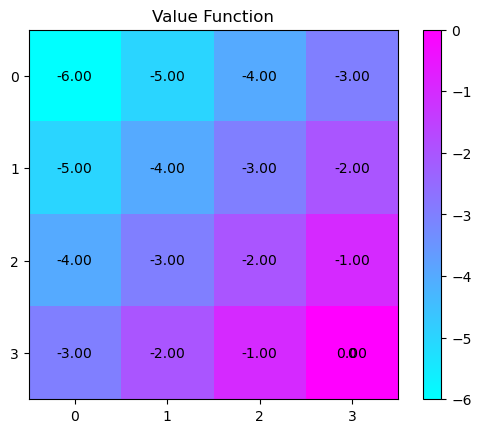

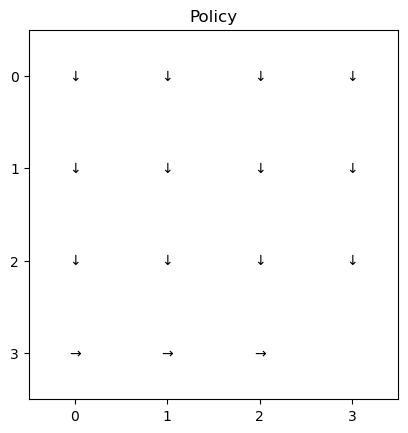

In [14]:
def value_iteration(env, gamma, epsilon):
    return policy, value_function


def plot_policy(env, policy):
    """
    This assumes that the policy is a dictionary mapping from state -> action (action is assumed to be an integer),
    so the policy must be deterministic.
    """
    num_rows, num_cols = env.grid_size, env.grid_size
    grid = np.zeros((num_rows, num_cols))
    actions = ['↑', '↓', '←', '→']

    fig, ax = plt.subplots()
    im = ax.imshow(grid, cmap='Greys')

    for i in range(num_rows):
        for j in range(num_cols):
            if (i == num_rows - 1) and (j == num_cols - 1):
                continue
            state = env._position_to_state(i, j)
            value = actions[policy[state]]
            ax.text(j, i, value, ha='center', va='center', color='black')

    ax.set_xticks(np.arange(num_cols))
    ax.set_yticks(np.arange(num_rows))
    ax.set_xticklabels(np.arange(num_cols))
    ax.set_yticklabels(np.arange(num_rows))
    ax.set_title('Policy')
    plt.show()
    
policy, value_function = value_iteration(env, 1, 0.000001)
plot_value_function(env, value_function)
plot_policy(env, policy)


How do the values compare to the random policy that you evaluated earlier?

Now that we have looked at some exact Dynamic Programming methods, we will move on to some Reinforcement Learning algorithms, beginning with Monte Carlo Control!

--- 

## Monte Carlo Control
We'll now focus on some Monte Carlo based algorithms. Monte Carlo Control is a family of RL algorithms that learns to find an optimal policy by repeatedly playing episodes of a given environment and estimating the expected return of each state-action pair based on the observed returns from those pairs in the played episodes, i.e. using a Monte Carlo approach to estimate the expected returns.

Below I have provided a class that implements an algorithm based on the first visit Monte Carlo estimates of the returns. First you should read through the code to see if you can understand it for yourself, and then I will add details of each method below.

In [15]:
import copy

class MonteCarloControl:
    def __init__(self, env, num_episodes=10000, gamma=0.99, epsilon=0.3):
        self.env = env
        self.test_env = copy.deepcopy(env)
        self.num_episodes = num_episodes
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.Q = {}
        self.N = {}
        self.possible_states = range(env.observation_space.n)
        self.num_states = env.observation_space.n
        for state in self.possible_states:
            self.Q[state] = np.random.uniform(-0.1, 0.1, self.num_actions)
            self.N[state] = np.zeros(self.num_actions)
            self.returns = {(s, a): [] for s in self.possible_states for a in range(self.num_actions)}
        self.policy = self.create_random_policy()
        self.epsilon = epsilon
        self.test_scores = []

    def create_random_policy(self):
        policy = {}
        for s in self.Q:
            policy[s] = np.random.dirichlet(np.ones(self.num_actions), size=1).flatten()
        return policy

    def get_action(self, state):
        probs = self.policy[state]
        action = np.random.choice(np.arange(len(probs)), p=probs)
        return action

    def generate_episode(self):
        episode = []
        state, _ = self.env.reset()
        done = False
        while not done:
            action = self.get_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            state = next_state
        return episode

    def update_Q(self, episode):
        G = 0
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if (state, action) not in [(x[0], x[1]) for x in episode[:t]]:
                self.N[state][action] += 1
                self.Q[state][action] += 1 / self.N[state][action] * (G - self.Q[state][action])
                self.policy[state] = np.zeros(self.num_actions)
                best_action = np.argmax(self.Q[state])
                self.policy[state] = np.array([self.epsilon / self.num_actions] * self.num_actions)
                self.policy[state][best_action] = 1 - self.epsilon + self.epsilon / self.num_actions

    def train(self):
        for episode in range(self.num_episodes):
            if (episode + 1) % 10 == 0:  # every 10 episodes, we test our algorithm and store the results for later
                scores = []
                for i in range(10):
                    scores.append(self.generate_test_episode())
                self.test_scores.append((episode + 1, np.mean(scores)))
            if (episode + 1) % 100 == 0:
                print(f"Starting episode {episode + 1}")
            episode = self.generate_episode()
            self.update_Q(episode)

    def generate_test_episode(self):
        state, _ = self.test_env.reset()
        done = False
        score = 0
        while not done:
            action = self.get_action(state)
            next_state, reward, terminated, truncated, _ = self.test_env.step(action)
            done = terminated or truncated
            state = next_state
            score += reward
        return score

In the `init` we pass in the environment, how many episodes we'd like to train for, the discount factor ($\gamma$) and our $\epsilon$ parameter for the soft policy. Recall that a soft policy is one which assigns probability $\frac{\epsilon}{|\mathcal{A}|}$ to all non-greedy actions, and the remaining $1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|}$ probability to the greedy value. Using the environment, we loop through all possible states and initialise our Q-table, `self.Q` and our visitation count `self.N`. We then also initialise the policy randomly using the `create_random_policy` method. 

Next, we have two straight forward methods: `get_action` and `generate_episode`. The former simply returns an action by sampling from the policy, whilst the latter runs through an episode similar to our above example, except here we append the `(state, action, reward)` tuple that we will use to update our Q-table. 

As the name suggests, the `update_Q` method is where we will use the episode information to update our Q-table. We receive an `episode` object, which is just a list of the tuples from the most recent episode. Using the list, we update Q using the first-visit Monte Carlo method, which will store the returns we saw from the *first* time we visited a state-action pair in the episode. 

To be more efficient, we do this dynamically using the following update: `NewEstimate = OldEstimate + 1/N * (NewValue - OldEstimate)`, where `NewValue` is the new return value we observe and `OldEstimate` is our previous estimate of the returns. Once we have update our Q-table, we then update our policy to be $\epsilon$-soft with respect to the new Q-Values. 

And there we have our first RL algorithm! Let's see if it can beat the random policy that we tested with earlier. 

Starting episode 100
Starting episode 200
Starting episode 300
Starting episode 400
Starting episode 500
Starting episode 600
Starting episode 700
Starting episode 800
Starting episode 900
Starting episode 1000


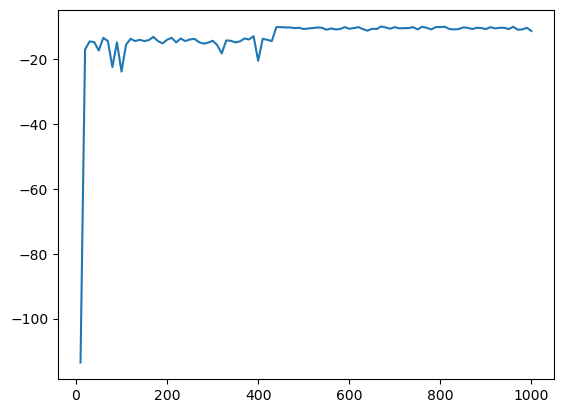

In [16]:
np.random.seed(3)
env = Gridworld(6)
monte_carlo = MonteCarloControl(env, num_episodes=1000, epsilon=0.05)
monte_carlo.train()
episodes = [x[0] for x in monte_carlo.test_scores]
scores = [x[1] for x in monte_carlo.test_scores]
plt.plot(episodes, scores)
plt.show()

We can see that the first time we test the algorithm it takes a long time to reach the goal state (over 100 steps!), but will quickly converge to a much more reasonable policy. **Try changing the size of the grid? What do you notice happening?**

---
## Temporal Difference Learning
We will now take a look at Temporal Difference (TD) Learning. One of the downsides of Monte Carlo learning is that we have to wait *until the end of an episode* before we receive any feedback about our actions. What if we don't want to wait this long? What if we are in a continuing task where there is no end to an episode? That is where TD Learning comes in, as rather than wait until the end of an episode to calculate the Monte Carlo returns, we simply bootstrap the remaining returns from our current estimate. The simplest example is the SARSA algorithm which makes the following update: $Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r(s, a) + \gamma Q(s', a') - Q(s, a) \right]$, where $a'$ is an action which we sample from our current policy $\pi$, i.e. $a' \sim \pi(\cdot|s')$. We can see that our returns are calculated by bootstrapping the value from the next state $s'$, rather than waiting for the end of the episode.

Let's write some code for this and see how it compares to the Monte-Carlo method. As before, I will provide the code for you to look through to understand for yourself and then you can read my comments below on which each method is doing. 

In [19]:
class SARSA:
    def __init__(self, env, alpha, gamma, epsilon, num_episodes=100000):
        self.env = env
        self.test_env = copy.deepcopy(env)
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.num_episodes = num_episodes
        self.num_actions = env.action_space.n
        self.Q = {}
        self.test_scores = []
        self.possible_states = range(env.observation_space.n)
        self.num_states = env.observation_space.n
        for state in self.possible_states:
            self.Q[state] = np.random.uniform(-0.1, 0.1, self.num_actions)

    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = self.env.action_space.sample()  # explore
        else:
            action = np.argmax(self.Q[state])  # exploit
        return action

    def update_Q(self, state, action, reward, next_state, next_action, terminated):
        td_target = reward + self.gamma * self.Q[next_state][next_action] * (1 - terminated)
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

    def train(self):
        for episode in range(self.num_episodes):
            if (episode + 1) % 10 == 0:
                scores = []
                for i in range(10):
                    scores.append(self.generate_test_episode())
                self.test_scores.append((episode + 1, np.mean(scores)))
            if (episode + 1) % 100 == 0:
                print(f"Starting episode {episode + 1}")
            state, _ = self.env.reset()
            action = self.choose_action(state)
            done = False
            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.choose_action(next_state)
                self.update_Q(state, action, reward, next_state, next_action, terminated)
                state = next_state
                action = next_action

    def generate_test_episode(self):
        state, _ = self.test_env.reset()
        done = False
        score = 0
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.test_env.step(action)
            done = terminated or truncated
            state = next_state
            score += reward
        return score

    def get_greedy_action(self, state):
        return np.argmax(self.Q[state])

The code follows the general class structure as the Monte Carlo method (in general, it is good practice to find a layout for your classes that you like and stick to it, so that any algorithms you write and publish are more readable). The only real changes are in the `train` method and the `update_Q` method. In the latter, we have just changed our update rule to be that of the SARSA algorithm. In the former, we have changed slightly the order of things -- now we take an action with the initial state, and pass in the next state to the `update_Q` method. Other than that, things are pretty much as they were!

Let's see how SARSA compared to the Monte-Carlo algorithm in Gridworld.

Starting episode 100
Starting episode 200
Starting episode 300
Starting episode 400
Starting episode 500
Starting episode 600
Starting episode 700
Starting episode 800
Starting episode 900
Starting episode 1000


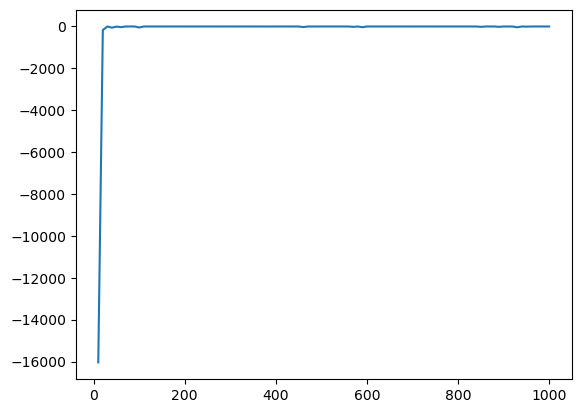

In [20]:
np.random.seed(3)
env = Gridworld(6)
sarsa = SARSA(env, 0.8, 0.99, 0.05, 1000)
sarsa.train()
episodes = [x[0] for x in sarsa.test_scores]
scores = [x[1] for x in sarsa.test_scores]
plt.plot(episodes, scores)
plt.show()

**How does SARSA compare to monte carlo? What about as the size of the grid increases?**

### Q-Learning
We are now going to test our first off-policy algorithm, Q-Learning. This algorithm was seminal to making *deep* RL successful, and we will look at the deep variant in our next lab, but for now we will stick with the tabular version. The update rule is similar to SARSA: $Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r(s, a) + \gamma \max_{a'}Q(s', a') - Q(s, a) \right]$. We still choose actions according to some exploratory policy, but the value we bootstrap from comes from the greedy policy. **Why is Q-Learning considered an off-policy algorithm?**

To write code for Q-Learning, we need to make minimal modifications to the SARSA algorithm. **Below I've attached a child class of the SARSA algorithm and I'll leave it as an exercise to make the changes.** Once you have made the changes, run the Q-Learning algorithm and see how it performs compared to Monte-Carlo and SARSA. 

In [21]:
class QLearning(SARSA):
    def __init__(self, **kwargs):
        super(QLearning, self).__init__(**kwargs)

    def update_Q(self, state, action, reward, next_state, terminated):
        pass

    def train(self):
        pass  # make sure to include the test episodes, at the same frequency as in SARSA

Starting episode 100
Starting episode 200
Starting episode 300
Starting episode 400
Starting episode 500
Starting episode 600
Starting episode 700
Starting episode 800
Starting episode 900
Starting episode 1000


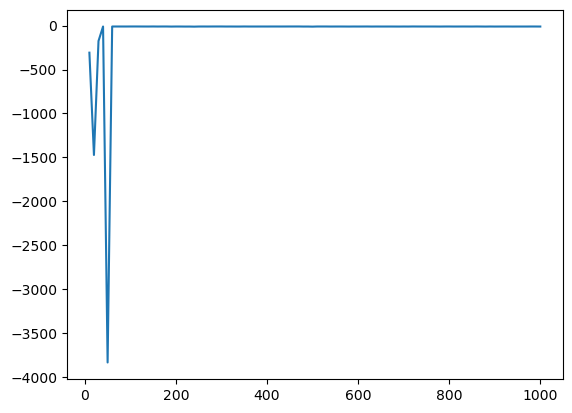

In [22]:
np.random.seed(3)
env = Gridworld(6)
q_learning = QLearning(env=env, alpha=0.8, gamma=0.99, epsilon=0.05, num_episodes=1000)
q_learning.train()
episodes = [x[0] for x in q_learning.test_scores]
scores = [x[1] for x in q_learning.test_scores]
plt.plot(episodes, scores)
plt.show()

How does Q-Learning compare to SARSA and Monte-Carlo? You can add the plots to the same axes and compare. You should notice that as the grid size increases, SARSA and Q-Learning start to outperform Monte-Carlo for the gridworld environment, in terms of how long the algorithm takes to run and also the performance. **Is this what you would expect and why?**

In the cell below, you can run SARSA and Q-Learning on the Windy Gridworld and the Cliff Walking environments. It might be interesting for you to modify the functions from earlier that plotted the policy to work with these environments (the biggest change is that they are no longer square) and see how the behaviour of the policies learnt by each algorithm differ, particularly in the cliff walking environment.

Starting episode 100
Starting episode 200
Starting episode 300
Starting episode 400
Starting episode 500
Starting episode 600
Starting episode 700
Starting episode 800
Starting episode 900
Starting episode 1000
Starting episode 100
Starting episode 200
Starting episode 300
Starting episode 400
Starting episode 500
Starting episode 600
Starting episode 700
Starting episode 800
Starting episode 900
Starting episode 1000


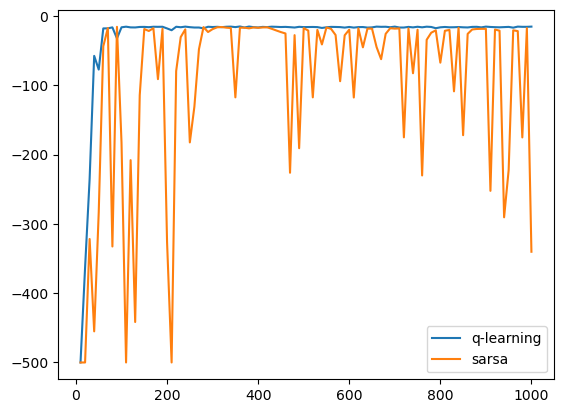

In [23]:
np.random.seed(3)
env = WindyGridworld()
sarsa = SARSA(env, 0.8, 0.99, 0.05, 1000)
sarsa.train()
sarsa_episodes = [x[0] for x in sarsa.test_scores]
sarsa_scores = [x[1] for x in sarsa.test_scores]

env = WindyGridworld()
q_learning = QLearning(env=env, alpha=0.8, gamma=0.99, epsilon=0.05, num_episodes=1000)
q_learning.train()
q_learning_episodes = [x[0] for x in q_learning.test_scores]
q_learning_scores = [x[1] for x in q_learning.test_scores]
plt.plot(q_learning_episodes, q_learning_scores, label='q-learning')
plt.plot(sarsa_episodes, sarsa_scores, label='sarsa')
plt.legend()
plt.show()

### Double Q-Learning
As you have seen in the lectures, Q-Learning suffers from a maximisation bias in the target: $r + \max_{a'}Q(s', a')$. Particularly in MDPs with many actions, meaning we take a maximum over many estimates, this can lead to a positive bias. For example, we could be in a state where the true $Q(s, a)$ is zero for most of the actions, but our estimates will be distributed above and below zero. The estimates above zero lead to the positive bias. 

To overcome this, Double Q-Learning was introduced. In Double Q-Learning, we maintain two estimates of the Q-values, $Q_1(s, a)$ and $Q_2(s, a)$. Instead of updating both estimates using a transition from the episode, we flip a coin and if, say, the coin lands on heads, then the update is given by $Q_1(s, a) \leftarrow Q_1(s, a) + \alpha \left[r + \gamma Q_2\left(s', \arg\max_{a'}Q_1(s', a')\right) - Q_1(s, a) \right]$.

**As an exercise, I'd like you to implement Double Q-Learning and compare it to Q-Learning in a test environment**. We can find the test environment in the `utils.py` file. The example is a simple toy example (taken frmo pg. 135 of the Sutton and Barto textbook). We have an MDP with two states, $A$ and $B$. In state $A$ we can take action left or right, both of which give 0 reward. The right action will lead to an immediate terminal state, whilst the left action will lead to state $B$. From state $B$, we have $N$ actions, all of which lead to a terminal state with reward drawn from a $\mbox{Normal}(-0.1, 1)$ distribution. The optimal action is to take the right action. Below, I will provide a Q-Learning class (essentially the same as what we implemented previously, but the init will be different as the example is custom made and not a gym environment so we need to be careful when defining the Q-Table etc.). For the Double Q-Learning, implement your own child class -- you will need to add a second Q-Table and change the update and act method.

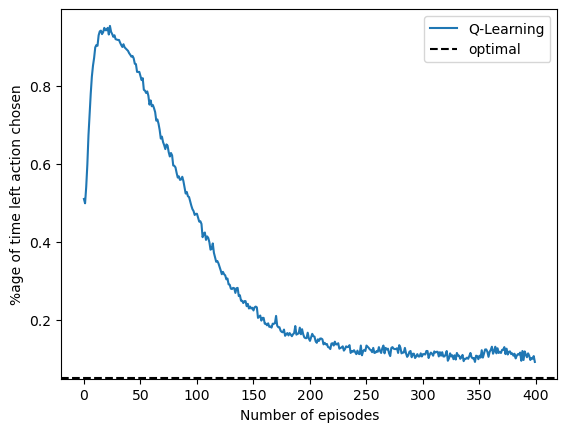

In [24]:
from utils import BiasExample  # here we import the toy environment
import matplotlib.pyplot as plt

class QLearning:
    def __init__(self, env, alpha, gamma, epsilon):
        self.env = env
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.num_actions = env.num_actions
        self.Q = {}
        for state in ["A", "B"]:
            if state == "A":
                self.Q[state] = np.zeros(2)  # because in state A we only have the left/right actions
            else:
                self.Q[state] = np.zeros(self.num_actions)  # in state B we have `num_actions` actions available.

    def choose_action(self, state):
        num_actions = 2 if state == "A" else self.num_actions
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(low=0, high=num_actions)
        else:
            max_q_val = self.Q[state].max()
            action = np.random.choice([a for a in range(len(self.Q[state])) if self.Q[state][a] == max_q_val])
        return action

    def update_Q(self, state, action, reward, next_state, terminated):
        td_target = reward + self.gamma * self.Q[next_state].max() * (1 - terminated)
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error


env = BiasExample(10)  # initialise the environment with 10 actions from state B
q_learning_opts = []  # keep track of how optimally we act across runs
for run in range(1000):
    q_learning_opts_ep = []  # keep track of how optimal we act in this run
    q_learning = QLearning(env, 0.1, 1, 0.1)  # after each run we need to reset the env
    for ep in range(400):
        state, _ = env.reset()
        done = False
        while not done:
            action = q_learning.choose_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            q_learning.update_Q(state, action, reward, next_state, terminated)
            state = next_state
        q_learning_opts_ep.append(1 - info['optimal'])  # we will make use of the info provided by the environment here, which tells us whether we acted optimally from state A or not.
    q_learning_opts.append(q_learning_opts_ep)

plt.plot(np.array(q_learning_opts).mean(axis=0), label="Q-Learning")
plt.axhline(y=0.05, color='black', linestyle='dashed', label='optimal')
plt.legend()
plt.ylabel("%age of time left action chosen")
plt.xlabel("Number of episodes")
plt.show()


In the above cell you should implement the Double Q-Learning code and then run a similar experiment, with the same hyperparameters, and add the Double Q-Learning performance to the plot. **How does it compare to Q-Learning? Does changing the hyperparameters help at all? How do the performances compare as you increase the number of actions?**